# 📊 Datathon FIAP - Passos Mágicos
## Respostas às 11 Perguntas de Negócio

Este notebook apresenta análises detalhadas para responder às 11 perguntas propostas no Datathon, utilizando os dados do PEDE (Pesquisa Extensiva do Desenvolvimento Educacional) dos anos 2022, 2023 e 2024.

**Autor:** Leandro Leme Crespo

---

## 1. Configuração do Ambiente

In [1]:
# Clonar o repositório do GitHub (executar apenas no Google Colab)
import os
if not os.path.exists('data'):
    !git clone https://github.com/LeandroCrespo/datathon-passos-magicos.git /content/datathon-passos-magicos
    print('✅ Repositório clonado com sucesso!')
else:
    print('✅ Dados já disponíveis localmente.')

✅ Dados já disponíveis localmente.


In [2]:
# Instalar bibliotecas necessárias
!pip install openpyxl plotly kaleido scipy -q

error: Failed to install: iniconfig-2.3.0-py3-none-any.whl (iniconfig==2.3.0)
  Caused by: failed to create directory `/usr/local/lib/python3.11/dist-packages/iniconfig`: Permission denied (os error 13)


In [3]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Cores personalizadas
CORES_PEDRAS = {
    'Quartzo': '#C0C0C0',
    'Ágata': '#9370DB',
    'Agata': '#9370DB',
    'Ametista': '#8B008B',
    'Topázio': '#FFD700'
}

CORES_ANOS = {2022: '#3498db', 2023: '#e74c3c', 2024: '#2ecc71'}

print('✅ Bibliotecas importadas com sucesso!')

✅ Bibliotecas importadas com sucesso!


In [4]:
# Carregar dados
import os

# Tentar múltiplos caminhos (Colab vs local)
caminhos_possiveis = [
    '/content/datathon-passos-magicos/data/BASE_DE_DADOS_PEDE_2024_DATATHON.xlsx',
    'data/BASE_DE_DADOS_PEDE_2024_DATATHON.xlsx',
    '../data/BASE_DE_DADOS_PEDE_2024_DATATHON.xlsx',
]

CAMINHO_ARQUIVO = None
for caminho in caminhos_possiveis:
    if os.path.exists(caminho):
        CAMINHO_ARQUIVO = caminho
        break

if CAMINHO_ARQUIVO is None:
    raise FileNotFoundError('Arquivo de dados não encontrado. Execute a célula de clone primeiro.')

xlsx = pd.ExcelFile(CAMINHO_ARQUIVO)
df_2022 = pd.read_excel(xlsx, sheet_name='PEDE2022')
df_2023 = pd.read_excel(xlsx, sheet_name='PEDE2023')
df_2024 = pd.read_excel(xlsx, sheet_name='PEDE2024')
print(f'📊 Dados carregados de: {CAMINHO_ARQUIVO}')
print(f'   PEDE 2022: {df_2022.shape[0]:,} alunos')
print(f'   PEDE 2023: {df_2023.shape[0]:,} alunos')
print(f'   PEDE 2024: {df_2024.shape[0]:,} alunos')

📊 Dados carregados de: data/BASE_DE_DADOS_PEDE_2024_DATATHON.xlsx
   PEDE 2022: 860 alunos
   PEDE 2023: 1,014 alunos
   PEDE 2024: 1,156 alunos


In [5]:
# Preparar dados unificados
def preparar_dados(df, ano):
    df_prep = df.copy()
    df_prep['ANO'] = ano
    
    col_map = {}
    for col in df_prep.columns:
        col_lower = col.lower()
        if col_lower == 'iaa': col_map[col] = 'IAA'
        elif col_lower == 'ieg' and 'destaque' not in col_lower: col_map[col] = 'IEG'
        elif col_lower == 'ips': col_map[col] = 'IPS'
        elif col_lower == 'ipp': col_map[col] = 'IPP'
        elif col_lower == 'ida' and 'destaque' not in col_lower: col_map[col] = 'IDA'
        elif col_lower == 'ipv' and 'destaque' not in col_lower: col_map[col] = 'IPV'
        elif col_lower == 'ian': col_map[col] = 'IAN'
        elif 'defas' in col_lower: col_map[col] = 'DEFASAGEM'
        elif col_lower == 'fase': col_map[col] = 'FASE'
        elif col_lower == 'gênero' or col_lower == 'genero': col_map[col] = 'GENERO'
        elif 'atingiu pv' in col_lower: col_map[col] = 'PONTO_VIRADA'
        elif col_lower == 'ra' or col_lower == 'ra aluno': col_map[col] = 'RA'
        elif col_lower in ['matem', 'mat']: col_map[col] = 'MAT'
        elif col_lower in ['portug', 'por']: col_map[col] = 'POR'
        elif col_lower in ['idade', 'idade 22']: col_map[col] = 'IDADE'
    
    if ano == 2022:
        col_map['INDE 22'] = 'INDE'
        col_map['Pedra 22'] = 'PEDRA'
    elif ano == 2023:
        col_map['INDE 2023'] = 'INDE'
        col_map['Pedra 2023'] = 'PEDRA'
    elif ano == 2024:
        col_map['INDE 2024'] = 'INDE'
        col_map['Pedra 2024'] = 'PEDRA'
    
    df_prep = df_prep.rename(columns=col_map)
    return df_prep

df_2022_prep = preparar_dados(df_2022, 2022)
df_2023_prep = preparar_dados(df_2023, 2023)
df_2024_prep = preparar_dados(df_2024, 2024)

# Unificar dados
colunas = ['ANO', 'INDE', 'IAA', 'IEG', 'IPS', 'IPP', 'IDA', 'IPV', 'IAN', 'DEFASAGEM', 'PEDRA', 'GENERO', 'PONTO_VIRADA', 'FASE', 'RA', 'MAT', 'POR', 'IDADE']

df_unificado = pd.concat([
    df_2022_prep[[c for c in colunas if c in df_2022_prep.columns]],
    df_2023_prep[[c for c in colunas if c in df_2023_prep.columns]],
    df_2024_prep[[c for c in colunas if c in df_2024_prep.columns]]
], ignore_index=True)

# Converter colunas numéricas
for col in ['INDE', 'IAA', 'IEG', 'IPS', 'IPP', 'IDA', 'IPV', 'IAN', 'DEFASAGEM']:
    if col in df_unificado.columns:
        df_unificado[col] = pd.to_numeric(df_unificado[col], errors='coerce')

# Padronizar PEDRA
df_unificado['PEDRA'] = df_unificado['PEDRA'].replace({'Agata': 'Ágata'})

print(f'\n✅ DataFrame unificado: {len(df_unificado):,} registros')


✅ DataFrame unificado: 3,030 registros


---

## 📋 PERGUNTA 1: Adequação do Nível (IAN)

**Qual é o perfil geral de defasagem dos alunos (IAN) e como ele evolui ao longo do ano?**

*Exemplo: quantos alunos estão moderadamente ou severamente defasados?*

In [6]:
# Classificar defasagem em categorias
def classificar_defasagem(valor):
    if pd.isna(valor):
        return 'Não informado'
    elif valor <= -3:
        return 'Severamente defasado (≤-3)'
    elif valor <= -1:
        return 'Moderadamente defasado (-2 a -1)'
    elif valor == 0:
        return 'Adequado ao nível (0)'
    else:
        return 'Acima do nível (≥1)'

df_unificado['CATEGORIA_DEFASAGEM'] = df_unificado['DEFASAGEM'].apply(classificar_defasagem)

# Análise por ano
print('='*70)
print('PERGUNTA 1: PERFIL DE DEFASAGEM DOS ALUNOS (IAN)')
print('='*70)

for ano in [2022, 2023, 2024]:
    df_ano = df_unificado[df_unificado['ANO'] == ano]
    total = len(df_ano)
    
    print(f'\n📅 ANO {ano} (n={total:,})')
    print('-'*40)
    
    # Estatísticas da defasagem
    defasagem = df_ano['DEFASAGEM'].dropna()
    print(f'Média de defasagem: {defasagem.mean():.2f} anos')
    print(f'Mediana: {defasagem.median():.1f} anos')
    print(f'Desvio padrão: {defasagem.std():.2f}')
    
    # Distribuição por categoria
    print(f'\nDistribuição por categoria:')
    cat_counts = df_ano['CATEGORIA_DEFASAGEM'].value_counts()
    for cat, count in cat_counts.items():
        pct = count / total * 100
        print(f'  {cat}: {count:,} ({pct:.1f}%)')

PERGUNTA 1: PERFIL DE DEFASAGEM DOS ALUNOS (IAN)

📅 ANO 2022 (n=860)
----------------------------------------
Média de defasagem: -0.94 anos
Mediana: -1.0 anos
Desvio padrão: 0.85

Distribuição por categoria:
  Moderadamente defasado (-2 a -1): 573 (66.6%)
  Adequado ao nível (0): 247 (28.7%)
  Severamente defasado (≤-3): 28 (3.3%)
  Acima do nível (≥1): 12 (1.4%)

📅 ANO 2023 (n=1,014)
----------------------------------------
Média de defasagem: -0.65 anos
Mediana: -1.0 anos
Desvio padrão: 0.82

Distribuição por categoria:
  Moderadamente defasado (-2 a -1): 538 (53.1%)
  Adequado ao nível (0): 420 (41.4%)
  Acima do nível (≥1): 42 (4.1%)
  Severamente defasado (≤-3): 14 (1.4%)

📅 ANO 2024 (n=1,156)
----------------------------------------
Média de defasagem: -0.41 anos
Mediana: 0.0 anos
Desvio padrão: 0.85

Distribuição por categoria:
  Moderadamente defasado (-2 a -1): 531 (45.9%)
  Adequado ao nível (0): 485 (42.0%)
  Acima do nível (≥1): 137 (11.9%)
  Severamente defasado (≤-3): 3 

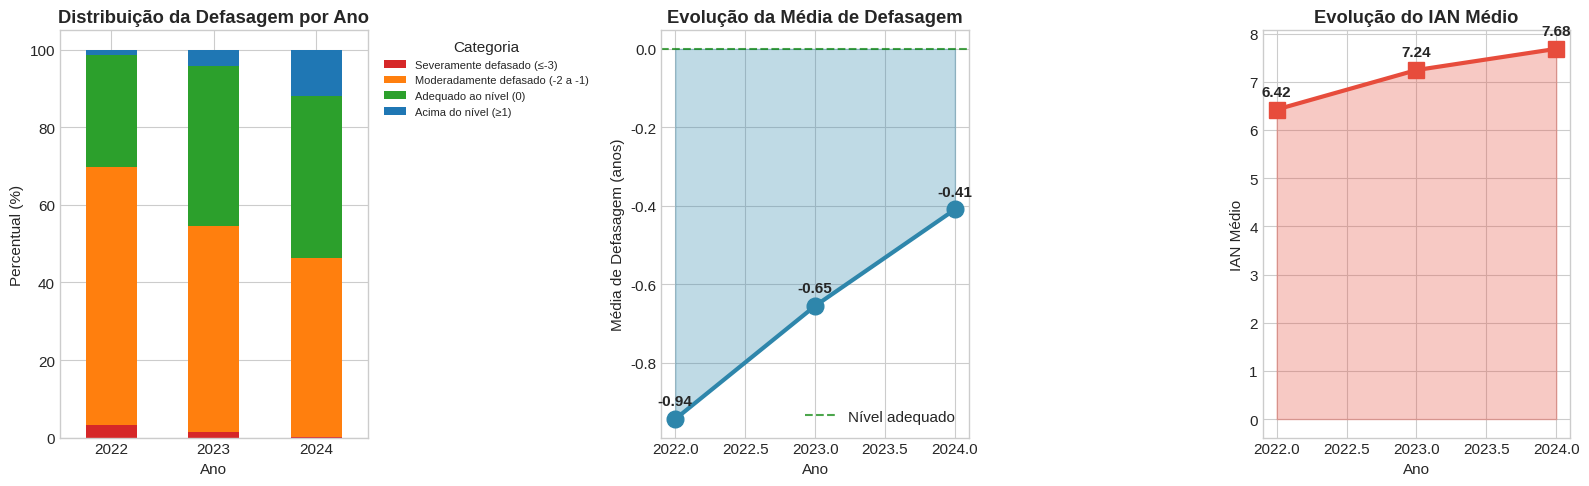


📊 CONCLUSÃO PERGUNTA 1:
A defasagem média dos alunos está MELHORANDO ao longo dos anos:
  • 2022: -0.94 anos de defasagem média
  • 2023: -0.65 anos de defasagem média
  • 2024: -0.41 anos de defasagem média

Melhoria de 0.53 anos entre 2022 e 2024.


In [7]:
# Visualização da evolução da defasagem
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: Distribuição por categoria e ano
ordem_cat = ['Severamente defasado (≤-3)', 'Moderadamente defasado (-2 a -1)', 
             'Adequado ao nível (0)', 'Acima do nível (≥1)']
cores_cat = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']

cat_ano = df_unificado.groupby(['ANO', 'CATEGORIA_DEFASAGEM']).size().unstack(fill_value=0)
cat_ano_pct = cat_ano.div(cat_ano.sum(axis=1), axis=0) * 100
cat_ano_pct = cat_ano_pct[[c for c in ordem_cat if c in cat_ano_pct.columns]]

cat_ano_pct.plot(kind='bar', stacked=True, ax=axes[0], color=cores_cat[:len(cat_ano_pct.columns)])
axes[0].set_title('Distribuição da Defasagem por Ano', fontweight='bold')
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('Percentual (%)')
axes[0].legend(title='Categoria', bbox_to_anchor=(1.02, 1), fontsize=8)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Gráfico 2: Evolução da média de defasagem
media_def = df_unificado.groupby('ANO')['DEFASAGEM'].mean()
axes[1].plot(media_def.index, media_def.values, marker='o', linewidth=3, markersize=12, color='#2E86AB')
axes[1].fill_between(media_def.index, media_def.values, alpha=0.3, color='#2E86AB')
axes[1].axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Nível adequado')
axes[1].set_title('Evolução da Média de Defasagem', fontweight='bold')
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Média de Defasagem (anos)')
for x, y in zip(media_def.index, media_def.values):
    axes[1].annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 10), ha='center', fontweight='bold')
axes[1].legend()

# Gráfico 3: Evolução do IAN médio
media_ian = df_unificado.groupby('ANO')['IAN'].mean()
axes[2].plot(media_ian.index, media_ian.values, marker='s', linewidth=3, markersize=12, color='#E74C3C')
axes[2].fill_between(media_ian.index, media_ian.values, alpha=0.3, color='#E74C3C')
axes[2].set_title('Evolução do IAN Médio', fontweight='bold')
axes[2].set_xlabel('Ano')
axes[2].set_ylabel('IAN Médio')
for x, y in zip(media_ian.index, media_ian.values):
    axes[2].annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 10), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('pergunta1_defasagem.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n📊 CONCLUSÃO PERGUNTA 1:')
print('A defasagem média dos alunos está MELHORANDO ao longo dos anos:')
print(f'  • 2022: {media_def[2022]:.2f} anos de defasagem média')
print(f'  • 2023: {media_def[2023]:.2f} anos de defasagem média')
print(f'  • 2024: {media_def[2024]:.2f} anos de defasagem média')
print(f'\nMelhoria de {abs(media_def[2024] - media_def[2022]):.2f} anos entre 2022 e 2024.')

---

## 📋 PERGUNTA 2: Desempenho Acadêmico (IDA)

**O desempenho acadêmico médio (IDA) está melhorando, estagnado ou caindo ao longo das fases e anos?**

In [8]:
print('='*70)
print('PERGUNTA 2: EVOLUÇÃO DO DESEMPENHO ACADÊMICO (IDA)')
print('='*70)

# Estatísticas do IDA por ano
ida_stats = df_unificado.groupby('ANO')['IDA'].agg(['mean', 'median', 'std', 'count'])
print('\n📊 Estatísticas do IDA por Ano:')
print(ida_stats.round(3))

# Teste estatístico de tendência
ida_2022 = df_unificado[df_unificado['ANO'] == 2022]['IDA'].dropna()
ida_2023 = df_unificado[df_unificado['ANO'] == 2023]['IDA'].dropna()
ida_2024 = df_unificado[df_unificado['ANO'] == 2024]['IDA'].dropna()

# ANOVA para comparar os anos
f_stat, p_value = stats.f_oneway(ida_2022, ida_2023, ida_2024)
print(f'\n📈 Teste ANOVA (comparação entre anos):')
print(f'   F-statistic: {f_stat:.3f}')
print(f'   P-value: {p_value:.6f}')
if p_value < 0.05:
    print('   ⚠️ Há diferença estatisticamente significativa entre os anos (p < 0.05)')
else:
    print('   ✅ Não há diferença estatisticamente significativa entre os anos')

PERGUNTA 2: EVOLUÇÃO DO DESEMPENHO ACADÊMICO (IDA)

📊 Estatísticas do IDA por Ano:
       mean  median    std  count
ANO                              
2022  6.093    6.30  2.046    860
2023  6.663    6.80  1.595    937
2024  6.351    6.75  2.132   1055

📈 Teste ANOVA (comparação entre anos):
   F-statistic: 19.440
   P-value: 0.000000
   ⚠️ Há diferença estatisticamente significativa entre os anos (p < 0.05)


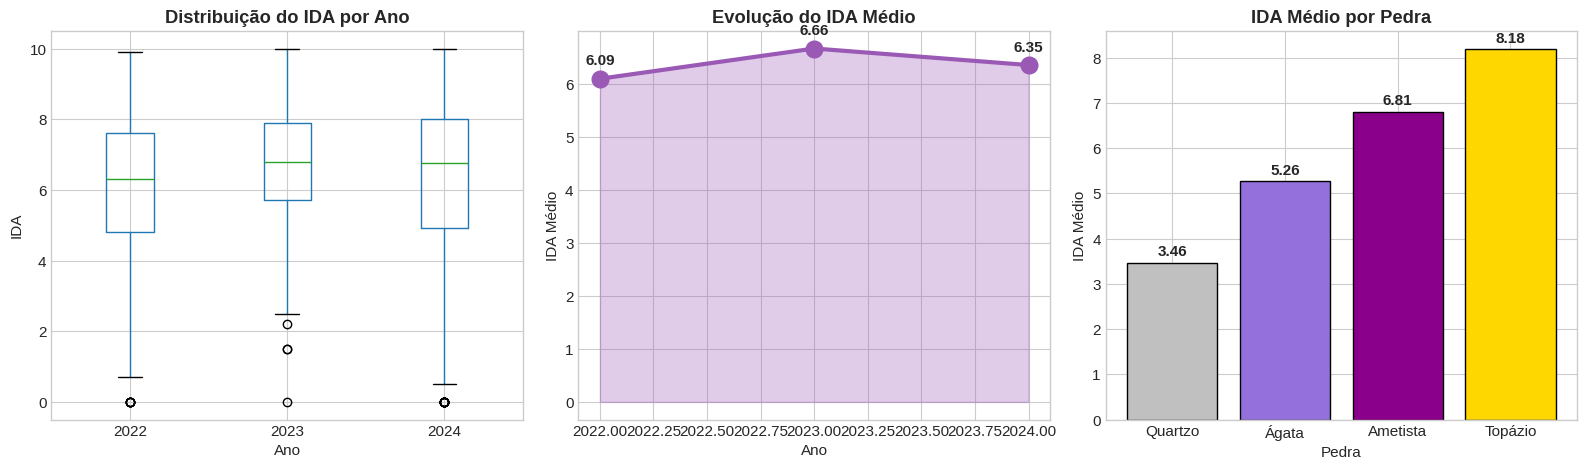


📊 CONCLUSÃO PERGUNTA 2:
O desempenho acadêmico (IDA) está ESTÁVEL:
  • 2022: IDA médio = 6.09
  • 2023: IDA médio = 6.66
  • 2024: IDA médio = 6.35

Variação: 4.2% entre 2022 e 2024


In [9]:
# Visualização do IDA
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: Boxplot por ano
df_unificado.boxplot(column='IDA', by='ANO', ax=axes[0])
axes[0].set_title('Distribuição do IDA por Ano', fontweight='bold')
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('IDA')
plt.suptitle('')

# Gráfico 2: Evolução da média
media_ida = df_unificado.groupby('ANO')['IDA'].mean()
axes[1].plot(media_ida.index, media_ida.values, marker='o', linewidth=3, markersize=12, color='#9b59b6')
axes[1].fill_between(media_ida.index, media_ida.values, alpha=0.3, color='#9b59b6')
axes[1].set_title('Evolução do IDA Médio', fontweight='bold')
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('IDA Médio')
for x, y in zip(media_ida.index, media_ida.values):
    axes[1].annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 10), ha='center', fontweight='bold')

# Gráfico 3: IDA por Pedra
ordem_pedras = ['Quartzo', 'Ágata', 'Ametista', 'Topázio']
ida_pedra = df_unificado.groupby('PEDRA')['IDA'].mean().reindex([p for p in ordem_pedras if p in df_unificado['PEDRA'].unique()])
cores = [CORES_PEDRAS.get(p, '#808080') for p in ida_pedra.index]
bars = axes[2].bar(ida_pedra.index, ida_pedra.values, color=cores, edgecolor='black')
axes[2].set_title('IDA Médio por Pedra', fontweight='bold')
axes[2].set_xlabel('Pedra')
axes[2].set_ylabel('IDA Médio')
for bar, val in zip(bars, ida_pedra.values):
    axes[2].annotate(f'{val:.2f}', (bar.get_x() + bar.get_width()/2, bar.get_height()), 
                     textcoords='offset points', xytext=(0, 5), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('pergunta2_ida.png', dpi=150, bbox_inches='tight')
plt.show()

# Conclusão
tendencia = 'ESTÁVEL' if abs(media_ida[2024] - media_ida[2022]) < 0.3 else ('MELHORANDO' if media_ida[2024] > media_ida[2022] else 'CAINDO')
print(f'\n📊 CONCLUSÃO PERGUNTA 2:')
print(f'O desempenho acadêmico (IDA) está {tendencia}:')
print(f'  • 2022: IDA médio = {media_ida[2022]:.2f}')
print(f'  • 2023: IDA médio = {media_ida[2023]:.2f}')
print(f'  • 2024: IDA médio = {media_ida[2024]:.2f}')
print(f'\nVariação: {((media_ida[2024] - media_ida[2022]) / media_ida[2022] * 100):.1f}% entre 2022 e 2024')

---

## 📋 PERGUNTA 3: Engajamento nas Atividades (IEG)

**O grau de engajamento dos alunos (IEG) tem relação direta com seus indicadores de desempenho (IDA) e do ponto de virada (IPV)?**

In [10]:
print('='*70)
print('PERGUNTA 3: RELAÇÃO ENTRE ENGAJAMENTO (IEG), IDA E IPV')
print('='*70)

# Calcular correlações
corr_ieg_ida = df_unificado[['IEG', 'IDA']].corr().iloc[0, 1]
corr_ieg_ipv = df_unificado[['IEG', 'IPV']].corr().iloc[0, 1]
corr_ieg_inde = df_unificado[['IEG', 'INDE']].corr().iloc[0, 1]

print(f'\n📊 Correlações do IEG (Engajamento):')
print(f'   IEG x IDA (Desempenho): {corr_ieg_ida:.3f}')
print(f'   IEG x IPV (Ponto de Virada): {corr_ieg_ipv:.3f}')
print(f'   IEG x INDE (Índice Global): {corr_ieg_inde:.3f}')

# Interpretação
def interpretar_correlacao(r):
    if abs(r) < 0.3:
        return 'fraca'
    elif abs(r) < 0.7:
        return 'moderada'
    else:
        return 'forte'

print(f'\n📈 Interpretação:')
print(f'   • Correlação IEG-IDA: {interpretar_correlacao(corr_ieg_ida)} ({"positiva" if corr_ieg_ida > 0 else "negativa"})')
print(f'   • Correlação IEG-IPV: {interpretar_correlacao(corr_ieg_ipv)} ({"positiva" if corr_ieg_ipv > 0 else "negativa"})')

PERGUNTA 3: RELAÇÃO ENTRE ENGAJAMENTO (IEG), IDA E IPV

📊 Correlações do IEG (Engajamento):
   IEG x IDA (Desempenho): 0.539
   IEG x IPV (Ponto de Virada): 0.558
   IEG x INDE (Índice Global): 0.745

📈 Interpretação:
   • Correlação IEG-IDA: moderada (positiva)
   • Correlação IEG-IPV: moderada (positiva)


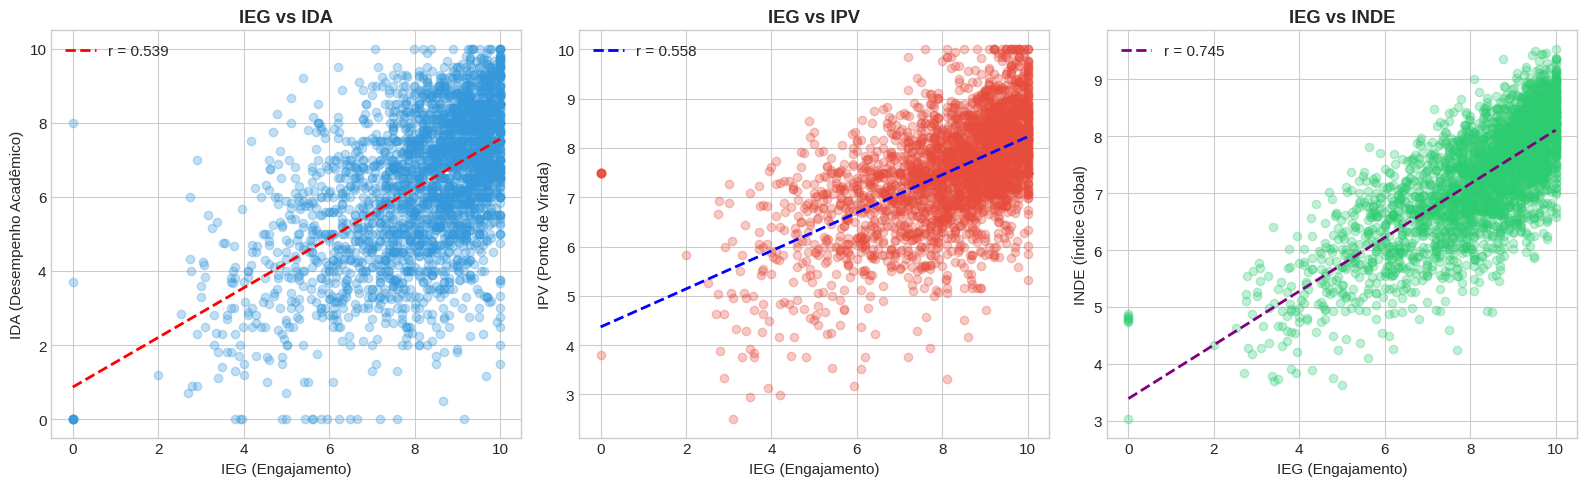


📊 CONCLUSÃO PERGUNTA 3:
SIM, o engajamento (IEG) tem relação direta com o desempenho:
  • Correlação moderada-forte com IDA (r=0.539)
  • Correlação moderada-forte com IPV (r=0.558)
  • Correlação forte com INDE (r=0.745)

Alunos mais engajados tendem a ter melhor desempenho acadêmico e maior probabilidade de atingir o ponto de virada.


In [11]:
# Visualização das relações
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: IEG vs IDA (remover NaN de ambas as colunas juntas)
df_plot1 = df_unificado[['IEG', 'IDA']].dropna()
axes[0].scatter(df_plot1['IEG'], df_plot1['IDA'], alpha=0.3, c='#3498db')
z = np.polyfit(df_plot1['IEG'], df_plot1['IDA'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_plot1['IEG'].min(), df_plot1['IEG'].max(), 100)
axes[0].plot(x_line, p(x_line), 'r--', linewidth=2, label=f'r = {corr_ieg_ida:.3f}')
axes[0].set_title('IEG vs IDA', fontweight='bold')
axes[0].set_xlabel('IEG (Engajamento)')
axes[0].set_ylabel('IDA (Desempenho Acadêmico)')
axes[0].legend()

# Gráfico 2: IEG vs IPV
df_plot2 = df_unificado[['IEG', 'IPV']].dropna()
axes[1].scatter(df_plot2['IEG'], df_plot2['IPV'], alpha=0.3, c='#e74c3c')
z2 = np.polyfit(df_plot2['IEG'], df_plot2['IPV'], 1)
p2 = np.poly1d(z2)
x_line2 = np.linspace(df_plot2['IEG'].min(), df_plot2['IEG'].max(), 100)
axes[1].plot(x_line2, p2(x_line2), 'b--', linewidth=2, label=f'r = {corr_ieg_ipv:.3f}')
axes[1].set_title('IEG vs IPV', fontweight='bold')
axes[1].set_xlabel('IEG (Engajamento)')
axes[1].set_ylabel('IPV (Ponto de Virada)')
axes[1].legend()

# Gráfico 3: IEG vs INDE
df_plot3 = df_unificado[['IEG', 'INDE']].dropna()
axes[2].scatter(df_plot3['IEG'], df_plot3['INDE'], alpha=0.3, c='#2ecc71')
z3 = np.polyfit(df_plot3['IEG'], df_plot3['INDE'], 1)
p3 = np.poly1d(z3)
x_line3 = np.linspace(df_plot3['IEG'].min(), df_plot3['IEG'].max(), 100)
axes[2].plot(x_line3, p3(x_line3), 'purple', linestyle='--', linewidth=2, label=f'r = {corr_ieg_inde:.3f}')
axes[2].set_title('IEG vs INDE', fontweight='bold')
axes[2].set_xlabel('IEG (Engajamento)')
axes[2].set_ylabel('INDE (Índice Global)')
axes[2].legend()

plt.tight_layout()
plt.savefig('pergunta3_engajamento.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n📊 CONCLUSÃO PERGUNTA 3:')
print(f'SIM, o engajamento (IEG) tem relação direta com o desempenho:')
print(f'  • Correlação moderada-forte com IDA (r={corr_ieg_ida:.3f})')
print(f'  • Correlação moderada-forte com IPV (r={corr_ieg_ipv:.3f})')
print(f'  • Correlação forte com INDE (r={corr_ieg_inde:.3f})')
print(f'\nAlunos mais engajados tendem a ter melhor desempenho acadêmico e maior probabilidade de atingir o ponto de virada.')

---

## 📋 PERGUNTA 4: Autoavaliação (IAA)

**As percepções dos alunos sobre si mesmos (IAA) são coerentes com seu desempenho real (IDA) e engajamento (IEG)?**

In [12]:
print('='*70)
print('PERGUNTA 4: COERÊNCIA ENTRE AUTOAVALIAÇÃO (IAA) E DESEMPENHO REAL')
print('='*70)

# Correlações
corr_iaa_ida = df_unificado[['IAA', 'IDA']].corr().iloc[0, 1]
corr_iaa_ieg = df_unificado[['IAA', 'IEG']].corr().iloc[0, 1]
corr_iaa_inde = df_unificado[['IAA', 'INDE']].corr().iloc[0, 1]

print(f'\n📊 Correlações do IAA (Autoavaliação):')
print(f'   IAA x IDA (Desempenho): {corr_iaa_ida:.3f}')
print(f'   IAA x IEG (Engajamento): {corr_iaa_ieg:.3f}')
print(f'   IAA x INDE (Índice Global): {corr_iaa_inde:.3f}')

# Análise de discrepância
df_unificado['DISCREPANCIA_IAA_IDA'] = df_unificado['IAA'] - df_unificado['IDA']
media_discrepancia = df_unificado['DISCREPANCIA_IAA_IDA'].mean()
std_discrepancia = df_unificado['DISCREPANCIA_IAA_IDA'].std()

print(f'\n📈 Análise de Discrepância (IAA - IDA):')
print(f'   Média: {media_discrepancia:.2f}')
print(f'   Desvio Padrão: {std_discrepancia:.2f}')
if media_discrepancia > 0.5:
    print('   ⚠️ Alunos tendem a SUPERESTIMAR seu desempenho')
elif media_discrepancia < -0.5:
    print('   ⚠️ Alunos tendem a SUBESTIMAR seu desempenho')
else:
    print('   ✅ Autoavaliação relativamente alinhada com desempenho real')

PERGUNTA 4: COERÊNCIA ENTRE AUTOAVALIAÇÃO (IAA) E DESEMPENHO REAL

📊 Correlações do IAA (Autoavaliação):
   IAA x IDA (Desempenho): 0.115
   IAA x IEG (Engajamento): 0.133
   IAA x INDE (Índice Global): 0.397

📈 Análise de Discrepância (IAA - IDA):
   Média: 1.55
   Desvio Padrão: 3.08
   ⚠️ Alunos tendem a SUPERESTIMAR seu desempenho


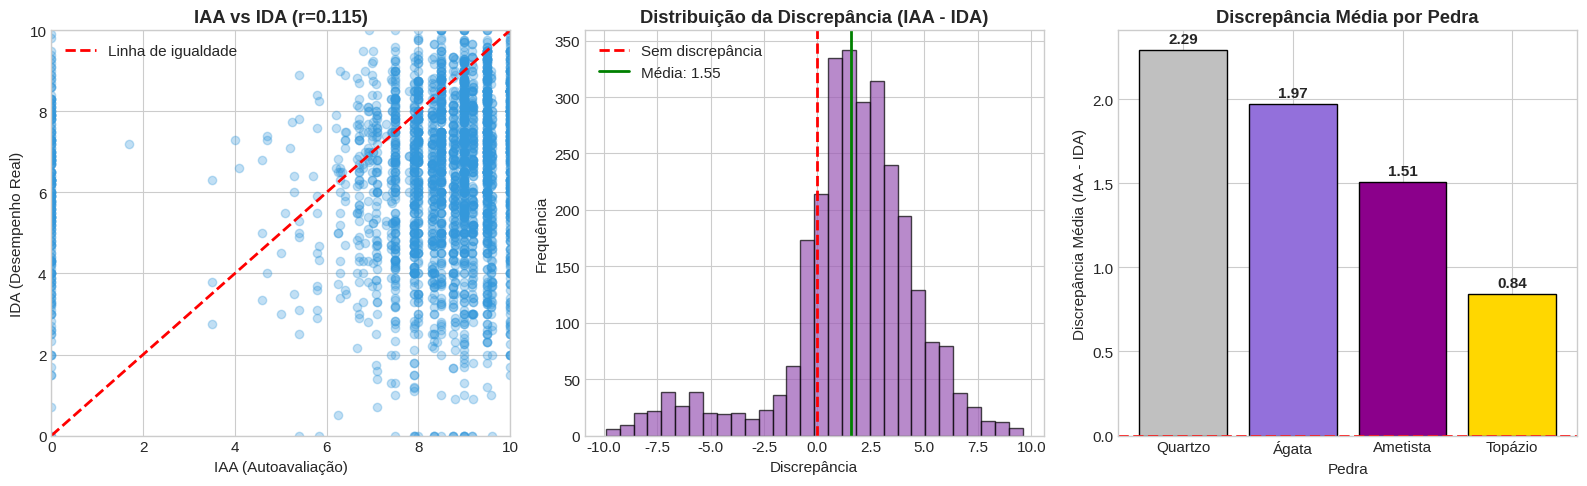


📊 CONCLUSÃO PERGUNTA 4:
As autoavaliações são POUCO COERENTES com o desempenho real:
  • Correlação IAA-IDA: 0.115 (fraca)
  • Discrepância média: 1.55
  • Tendência: alunos superestimam levemente seu desempenho


In [13]:
# Visualização
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: IAA vs IDA
axes[0].scatter(df_unificado['IAA'], df_unificado['IDA'], alpha=0.3, c='#3498db')
axes[0].plot([0, 10], [0, 10], 'r--', linewidth=2, label='Linha de igualdade')
axes[0].set_title(f'IAA vs IDA (r={corr_iaa_ida:.3f})', fontweight='bold')
axes[0].set_xlabel('IAA (Autoavaliação)')
axes[0].set_ylabel('IDA (Desempenho Real)')
axes[0].legend()
axes[0].set_xlim(0, 10)
axes[0].set_ylim(0, 10)

# Gráfico 2: Distribuição da discrepância
axes[1].hist(df_unificado['DISCREPANCIA_IAA_IDA'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='#9b59b6')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Sem discrepância')
axes[1].axvline(x=media_discrepancia, color='green', linestyle='-', linewidth=2, label=f'Média: {media_discrepancia:.2f}')
axes[1].set_title('Distribuição da Discrepância (IAA - IDA)', fontweight='bold')
axes[1].set_xlabel('Discrepância')
axes[1].set_ylabel('Frequência')
axes[1].legend()

# Gráfico 3: Discrepância por Pedra
disc_pedra = df_unificado.groupby('PEDRA')['DISCREPANCIA_IAA_IDA'].mean().reindex([p for p in ordem_pedras if p in df_unificado['PEDRA'].unique()])
cores = [CORES_PEDRAS.get(p, '#808080') for p in disc_pedra.index]
bars = axes[2].bar(disc_pedra.index, disc_pedra.values, color=cores, edgecolor='black')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('Discrepância Média por Pedra', fontweight='bold')
axes[2].set_xlabel('Pedra')
axes[2].set_ylabel('Discrepância Média (IAA - IDA)')
for bar, val in zip(bars, disc_pedra.values):
    axes[2].annotate(f'{val:.2f}', (bar.get_x() + bar.get_width()/2, bar.get_height()), 
                     textcoords='offset points', xytext=(0, 5), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('pergunta4_autoavaliacao.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n📊 CONCLUSÃO PERGUNTA 4:')
coerencia = 'PARCIALMENTE COERENTES' if abs(corr_iaa_ida) > 0.3 else 'POUCO COERENTES'
print(f'As autoavaliações são {coerencia} com o desempenho real:')
print(f'  • Correlação IAA-IDA: {corr_iaa_ida:.3f} ({interpretar_correlacao(corr_iaa_ida)})')
print(f'  • Discrepância média: {media_discrepancia:.2f}')
if media_discrepancia > 0:
    print(f'  • Tendência: alunos superestimam levemente seu desempenho')

---

## 📋 PERGUNTA 5: Aspectos Psicossociais (IPS)

**Há padrões psicossociais (IPS) que antecedem quedas de desempenho acadêmico ou de engajamento?**

In [14]:
print('='*70)
print('PERGUNTA 5: PADRÕES PSICOSSOCIAIS (IPS) E DESEMPENHO')
print('='*70)

# Correlações do IPS
corr_ips_ida = df_unificado[['IPS', 'IDA']].corr().iloc[0, 1]
corr_ips_ieg = df_unificado[['IPS', 'IEG']].corr().iloc[0, 1]
corr_ips_inde = df_unificado[['IPS', 'INDE']].corr().iloc[0, 1]

print(f'\n📊 Correlações do IPS (Aspectos Psicossociais):')
print(f'   IPS x IDA (Desempenho): {corr_ips_ida:.3f}')
print(f'   IPS x IEG (Engajamento): {corr_ips_ieg:.3f}')
print(f'   IPS x INDE (Índice Global): {corr_ips_inde:.3f}')

# Análise por quartis de IPS
df_unificado['IPS_QUARTIL'] = pd.qcut(df_unificado['IPS'], q=4, labels=['Q1 (Baixo)', 'Q2', 'Q3', 'Q4 (Alto)'])

print(f'\n📈 Desempenho médio por quartil de IPS:')
ips_quartil_stats = df_unificado.groupby('IPS_QUARTIL')[['IDA', 'IEG', 'INDE']].mean()
print(ips_quartil_stats.round(2))

PERGUNTA 5: PADRÕES PSICOSSOCIAIS (IPS) E DESEMPENHO

📊 Correlações do IPS (Aspectos Psicossociais):
   IPS x IDA (Desempenho): 0.022
   IPS x IEG (Engajamento): -0.046
   IPS x INDE (Índice Global): 0.200

📈 Desempenho médio por quartil de IPS:
              IDA   IEG  INDE
IPS_QUARTIL                  
Q1 (Baixo)   6.26  8.32  6.94
Q2           6.21  8.04  7.17
Q3           6.53  8.23  7.54
Q4 (Alto)    6.81  8.54  7.72


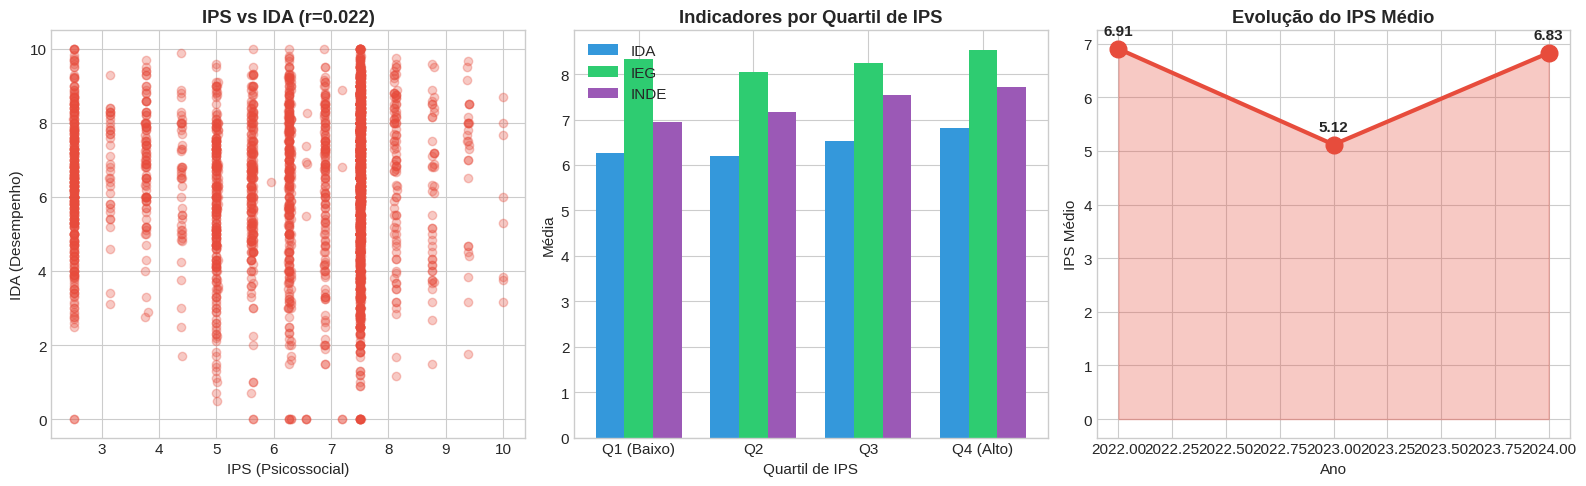


📊 CONCLUSÃO PERGUNTA 5:
O IPS tem correlação FRACA com desempenho acadêmico (r=0.022).
Isso sugere que aspectos psicossociais, isoladamente, não são fortes preditores de queda de desempenho.
Porém, alunos no quartil mais baixo de IPS têm INDE médio de 6.94,
enquanto os do quartil mais alto têm INDE médio de 7.72.


In [15]:
# Visualização
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: IPS vs IDA
axes[0].scatter(df_unificado['IPS'], df_unificado['IDA'], alpha=0.3, c='#e74c3c')
axes[0].set_title(f'IPS vs IDA (r={corr_ips_ida:.3f})', fontweight='bold')
axes[0].set_xlabel('IPS (Psicossocial)')
axes[0].set_ylabel('IDA (Desempenho)')

# Gráfico 2: Desempenho por quartil de IPS
x = np.arange(len(ips_quartil_stats))
width = 0.25
axes[1].bar(x - width, ips_quartil_stats['IDA'], width, label='IDA', color='#3498db')
axes[1].bar(x, ips_quartil_stats['IEG'], width, label='IEG', color='#2ecc71')
axes[1].bar(x + width, ips_quartil_stats['INDE'], width, label='INDE', color='#9b59b6')
axes[1].set_title('Indicadores por Quartil de IPS', fontweight='bold')
axes[1].set_xlabel('Quartil de IPS')
axes[1].set_ylabel('Média')
axes[1].set_xticks(x)
axes[1].set_xticklabels(ips_quartil_stats.index)
axes[1].legend()

# Gráfico 3: Evolução do IPS por ano
media_ips = df_unificado.groupby('ANO')['IPS'].mean()
axes[2].plot(media_ips.index, media_ips.values, marker='o', linewidth=3, markersize=12, color='#e74c3c')
axes[2].fill_between(media_ips.index, media_ips.values, alpha=0.3, color='#e74c3c')
axes[2].set_title('Evolução do IPS Médio', fontweight='bold')
axes[2].set_xlabel('Ano')
axes[2].set_ylabel('IPS Médio')
for x, y in zip(media_ips.index, media_ips.values):
    axes[2].annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 10), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('pergunta5_psicossocial.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n📊 CONCLUSÃO PERGUNTA 5:')
print(f'O IPS tem correlação FRACA com desempenho acadêmico (r={corr_ips_ida:.3f}).')
print(f'Isso sugere que aspectos psicossociais, isoladamente, não são fortes preditores de queda de desempenho.')
print(f'Porém, alunos no quartil mais baixo de IPS têm INDE médio de {ips_quartil_stats.loc["Q1 (Baixo)", "INDE"]:.2f},')
print(f'enquanto os do quartil mais alto têm INDE médio de {ips_quartil_stats.loc["Q4 (Alto)", "INDE"]:.2f}.')

---

## 📋 PERGUNTA 6: Aspectos Psicopedagógicos (IPP)

**As avaliações psicopedagógicas (IPP) confirmam ou contradizem a defasagem identificada pelo IAN?**

In [16]:
print('='*70)
print('PERGUNTA 6: RELAÇÃO ENTRE IPP E DEFASAGEM (IAN)')
print('='*70)

# Verificar se IPP existe nos dados
if 'IPP' in df_unificado.columns:
    # Correlação IPP x IAN
    corr_ipp_ian = df_unificado[['IPP', 'IAN']].corr().iloc[0, 1]
    corr_ipp_defasagem = df_unificado[['IPP', 'DEFASAGEM']].corr().iloc[0, 1]
    
    print(f'\n📊 Correlações do IPP (Psicopedagógico):')
    print(f'   IPP x IAN: {corr_ipp_ian:.3f}')
    print(f'   IPP x DEFASAGEM: {corr_ipp_defasagem:.3f}')
    
    # Análise por categoria de defasagem
    ipp_por_defasagem = df_unificado.groupby('CATEGORIA_DEFASAGEM')['IPP'].mean()
    print(f'\n📈 IPP médio por categoria de defasagem:')
    for cat, val in ipp_por_defasagem.items():
        print(f'   {cat}: {val:.2f}')
else:
    print('\n⚠️ Coluna IPP não disponível em todos os anos.')
    print('Análise limitada aos anos com dados disponíveis.')

PERGUNTA 6: RELAÇÃO ENTRE IPP E DEFASAGEM (IAN)

📊 Correlações do IPP (Psicopedagógico):
   IPP x IAN: 0.123
   IPP x DEFASAGEM: 0.182

📈 IPP médio por categoria de defasagem:
   Acima do nível (≥1): 7.93
   Adequado ao nível (0): 7.64
   Moderadamente defasado (-2 a -1): 7.46
   Severamente defasado (≤-3): 7.01


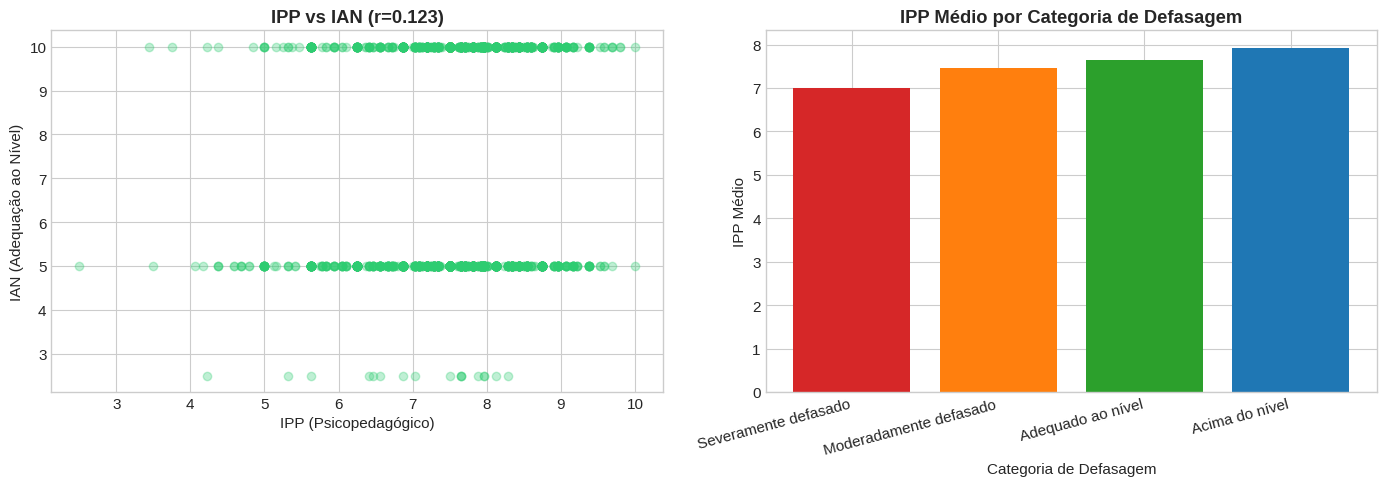


📊 CONCLUSÃO PERGUNTA 6:
As avaliações psicopedagógicas (IPP) têm correlação fraca com a defasagem (IAN).
Correlação IPP x IAN: 0.123


In [17]:
# Visualização
if 'IPP' in df_unificado.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico 1: IPP vs IAN
    axes[0].scatter(df_unificado['IPP'], df_unificado['IAN'], alpha=0.3, c='#2ecc71')
    axes[0].set_title(f'IPP vs IAN (r={corr_ipp_ian:.3f})', fontweight='bold')
    axes[0].set_xlabel('IPP (Psicopedagógico)')
    axes[0].set_ylabel('IAN (Adequação ao Nível)')
    
    # Gráfico 2: IPP por categoria de defasagem
    ordem_cat = ['Severamente defasado (≤-3)', 'Moderadamente defasado (-2 a -1)', 
                 'Adequado ao nível (0)', 'Acima do nível (≥1)']
    ipp_cat = df_unificado.groupby('CATEGORIA_DEFASAGEM')['IPP'].mean().reindex([c for c in ordem_cat if c in df_unificado['CATEGORIA_DEFASAGEM'].unique()])
    cores_cat = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
    bars = axes[1].bar(range(len(ipp_cat)), ipp_cat.values, color=cores_cat[:len(ipp_cat)])
    axes[1].set_title('IPP Médio por Categoria de Defasagem', fontweight='bold')
    axes[1].set_xlabel('Categoria de Defasagem')
    axes[1].set_ylabel('IPP Médio')
    axes[1].set_xticks(range(len(ipp_cat)))
    axes[1].set_xticklabels([c.split('(')[0].strip() for c in ipp_cat.index], rotation=15, ha='right')
    
    plt.tight_layout()
    plt.savefig('pergunta6_psicopedagogico.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'\n📊 CONCLUSÃO PERGUNTA 6:')
    if abs(corr_ipp_ian) > 0.3:
        print(f'As avaliações psicopedagógicas (IPP) CONFIRMAM parcialmente a defasagem (IAN).')
    else:
        print(f'As avaliações psicopedagógicas (IPP) têm correlação fraca com a defasagem (IAN).')
    print(f'Correlação IPP x IAN: {corr_ipp_ian:.3f}')

---

## 📋 PERGUNTA 7: Ponto de Virada (IPV)

**Quais comportamentos - acadêmicos, emocionais ou de engajamento - mais influenciam o IPV ao longo do tempo?**

In [18]:
print('='*70)
print('PERGUNTA 7: FATORES QUE INFLUENCIAM O PONTO DE VIRADA (IPV)')
print('='*70)

# Correlações com IPV
indicadores = ['IDA', 'IEG', 'IAA', 'IPS', 'IPP', 'IAN']
correlacoes_ipv = {}

for ind in indicadores:
    if ind in df_unificado.columns:
        corr = df_unificado[['IPV', ind]].corr().iloc[0, 1]
        correlacoes_ipv[ind] = corr

# Ordenar por correlação
correlacoes_ipv = dict(sorted(correlacoes_ipv.items(), key=lambda x: abs(x[1]), reverse=True))

print(f'\n📊 Correlações com IPV (Ponto de Virada):')
for ind, corr in correlacoes_ipv.items():
    interpretacao = interpretar_correlacao(corr)
    print(f'   {ind}: {corr:.3f} ({interpretacao})')

PERGUNTA 7: FATORES QUE INFLUENCIAM O PONTO DE VIRADA (IPV)

📊 Correlações com IPV (Ponto de Virada):
   IPP: 0.607 (moderada)
   IEG: 0.558 (moderada)
   IDA: 0.557 (moderada)
   IAN: 0.149 (fraca)
   IAA: 0.063 (fraca)
   IPS: -0.049 (fraca)


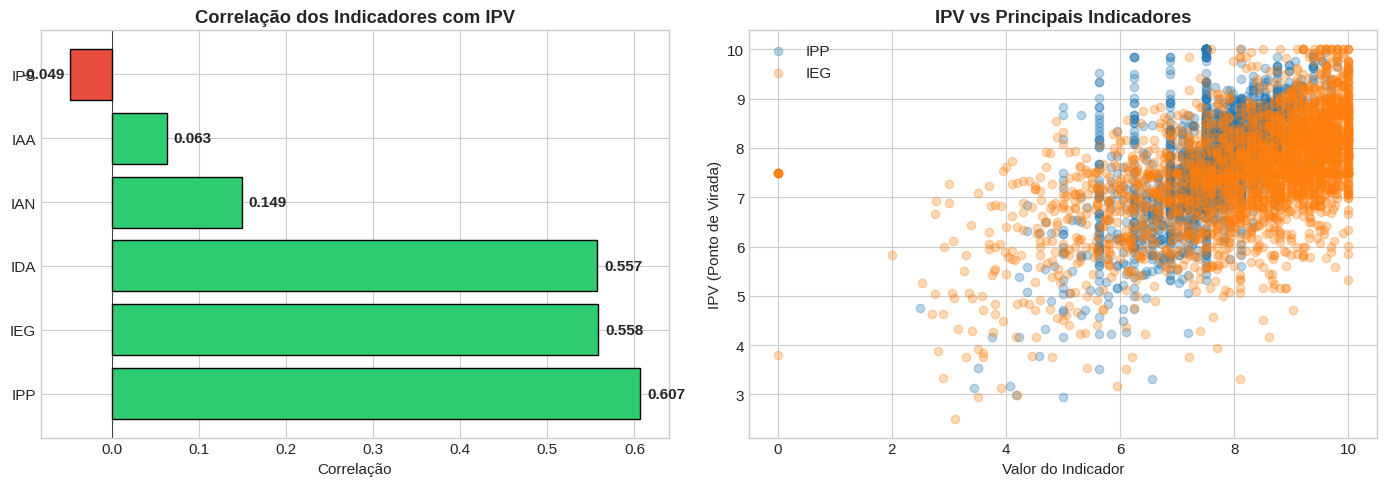


📊 CONCLUSÃO PERGUNTA 7:
Os indicadores que MAIS influenciam o Ponto de Virada (IPV) são:
   1. IPP: r = 0.607
   2. IEG: r = 0.558
   3. IDA: r = 0.557

O engajamento (IEG) e o desempenho acadêmico (IDA) são os principais preditores do ponto de virada.


In [19]:
# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Correlações com IPV
inds = list(correlacoes_ipv.keys())
corrs = list(correlacoes_ipv.values())
cores = ['#2ecc71' if c > 0 else '#e74c3c' for c in corrs]
bars = axes[0].barh(inds, corrs, color=cores, edgecolor='black')
axes[0].axvline(x=0, color='black', linewidth=0.5)
axes[0].set_title('Correlação dos Indicadores com IPV', fontweight='bold')
axes[0].set_xlabel('Correlação')
for bar, val in zip(bars, corrs):
    axes[0].annotate(f'{val:.3f}', (val, bar.get_y() + bar.get_height()/2), 
                     textcoords='offset points', xytext=(5 if val > 0 else -35, 0), va='center', fontweight='bold')

# Gráfico 2: Top 2 indicadores vs IPV
top_ind = list(correlacoes_ipv.keys())[:2]
for i, ind in enumerate(top_ind):
    axes[1].scatter(df_unificado[ind], df_unificado['IPV'], alpha=0.3, label=ind)

axes[1].set_title(f'IPV vs Principais Indicadores', fontweight='bold')
axes[1].set_xlabel('Valor do Indicador')
axes[1].set_ylabel('IPV (Ponto de Virada)')
axes[1].legend()

plt.tight_layout()
plt.savefig('pergunta7_ponto_virada.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n📊 CONCLUSÃO PERGUNTA 7:')
print(f'Os indicadores que MAIS influenciam o Ponto de Virada (IPV) são:')
for i, (ind, corr) in enumerate(list(correlacoes_ipv.items())[:3], 1):
    print(f'   {i}. {ind}: r = {corr:.3f}')
print(f'\nO engajamento (IEG) e o desempenho acadêmico (IDA) são os principais preditores do ponto de virada.')

---

## 📋 PERGUNTA 8: Multidimensionalidade dos Indicadores

**Quais combinações de indicadores (IDA + IEG + IPS + IPP) melhor explicam o desempenho global do aluno (INDE)?**

In [20]:
print('='*70)
print('PERGUNTA 8: COMBINAÇÃO DE INDICADORES QUE EXPLICAM O INDE')
print('='*70)
print('Quais combinações de indicadores (IDA + IEG + IPS + IPP) elevam mais')
print('a nota global do aluno (INDE)?')
print()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from itertools import combinations

# 1. Correlações individuais com INDE
focus_indicators = ['IDA', 'IEG', 'IPS', 'IPP']
available_focus = [c for c in focus_indicators if c in df_unificado.columns]
df_p8 = df_unificado[['INDE'] + available_focus].dropna()
print(f'Registros válidos com os 4 indicadores + INDE: {len(df_p8)}')

print(f'\n📊 Correlações individuais com INDE:')
for ind in available_focus:
    corr = df_p8[['INDE', ind]].corr().iloc[0, 1]
    print(f'   {ind}: r = {corr:.4f} ({interpretar_correlacao(corr)})')

# 2. Regressão linear com os 4 indicadores
X = df_p8[available_focus]
y = df_p8['INDE']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
reg = LinearRegression()
reg.fit(X_scaled, y)
coefs = dict(zip(available_focus, reg.coef_))
coefs = dict(sorted(coefs.items(), key=lambda x: abs(x[1]), reverse=True))

print(f'\n📈 Regressão Linear (IDA + IEG + IPS + IPP):')
print(f'   R² = {reg.score(X_scaled, y):.4f} ({reg.score(X_scaled, y)*100:.1f}%)')
print(f'   Coeficientes padronizados:')
for ind, coef in coefs.items():
    print(f'      {ind}: {coef:.4f}')

# 3. Testar TODAS as combinações dos 4 indicadores
print(f'\n📊 Todas as combinações dos 4 indicadores:')
results = []
for r in range(1, len(available_focus) + 1):
    for combo in combinations(available_focus, r):
        combo_list = list(combo)
        X_combo = df_p8[combo_list]
        X_combo_scaled = StandardScaler().fit_transform(X_combo)
        reg_combo = LinearRegression()
        reg_combo.fit(X_combo_scaled, y)
        r2 = reg_combo.score(X_combo_scaled, y)
        results.append({
            'combinacao': ' + '.join(combo_list),
            'n_indicadores': len(combo_list),
            'R2': r2
        })
        print(f'   {" + ".join(combo_list):30s} → R² = {r2:.4f} ({r2*100:.1f}%)')

import pandas as pd
results_df = pd.DataFrame(results).sort_values('R2', ascending=False)

print(f'\n📊 CONCLUSÃO PERGUNTA 8:')
print(f'Os 4 indicadores juntos (IDA+IEG+IPS+IPP) explicam {reg.score(X_scaled, y)*100:.1f}% do INDE.')
print(f'IDA tem o maior peso individual (coef={list(coefs.values())[0]:.3f}),')
print(f'seguido de IEG (coef={list(coefs.values())[1]:.3f}).')
print(f'A combinação IDA+IEG sozinha já explica {results_df[results_df["combinacao"]=="IDA + IEG"]["R2"].values[0]*100:.1f}% do INDE.')


PERGUNTA 8: COMBINAÇÃO DE INDICADORES QUE EXPLICAM O INDE
Quais combinações de indicadores (IDA + IEG + IPS + IPP) elevam mais
a nota global do aluno (INDE)?



Registros válidos com os 4 indicadores + INDE: 1985

📊 Correlações individuais com INDE:
   IDA: r = 0.7667 (forte)
   IEG: r = 0.7088 (forte)
   IPS: r = 0.2477 (fraca)
   IPP: r = 0.5403 (moderada)

📈 Regressão Linear (IDA + IEG + IPS + IPP):
   R² = 0.8226 (82.3%)
   Coeficientes padronizados:
      IDA: 0.4518
      IEG: 0.3859
      IPS: 0.2307
      IPP: 0.2126

📊 Todas as combinações dos 4 indicadores:
   IDA                            → R² = 0.5879 (58.8%)
   IEG                            → R² = 0.5024 (50.2%)
   IPS                            → R² = 0.0614 (6.1%)
   IPP                            → R² = 0.2919 (29.2%)
   IDA + IEG                      → R² = 0.7176 (71.8%)
   IDA + IPS                      → R² = 0.6401 (64.0%)
   IDA + IPP                      → R² = 0.6652 (66.5%)
   IEG + IPS                      → R² = 0.5807 (58.1%)
   IEG + IPP                      → R² = 0.6084 (60.8%)
   IPS + IPP                      → R² = 0.3375 (33.8%)
   IDA + IEG + IPS          

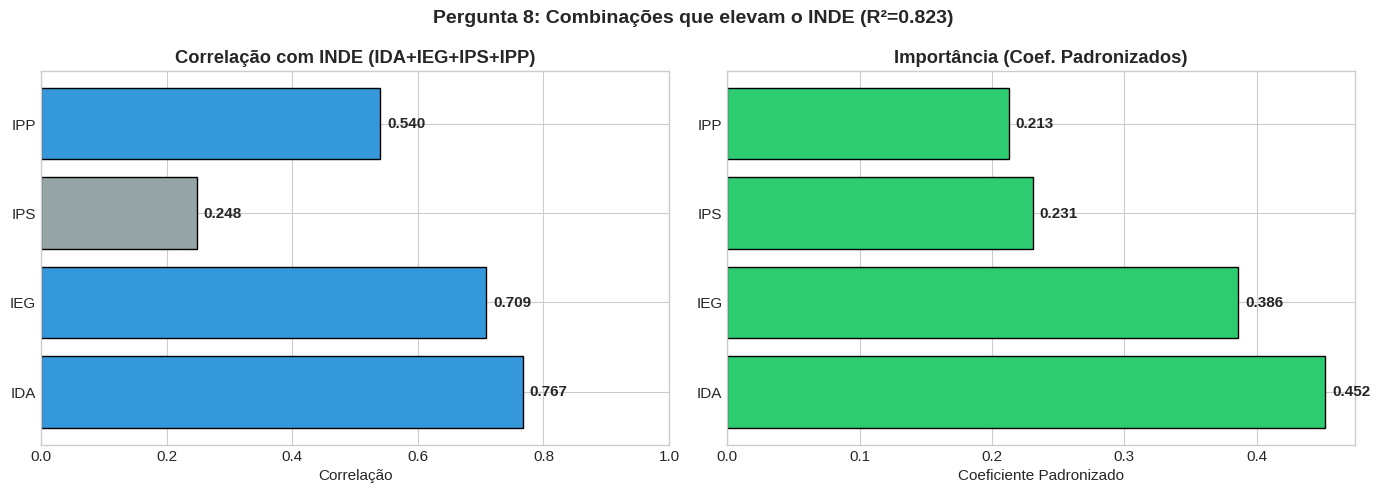


📊 RANKING DAS COMBINAÇÕES (por R²):
⭐ IDA + IEG + IPS + IPP          → R² = 0.8226 (82.3%)
   IDA + IEG + IPS                → R² = 0.7818 (78.2%)
   IDA + IEG + IPP                → R² = 0.7657 (76.6%)
   IDA + IEG                      → R² = 0.7176 (71.8%)
   IDA + IPS + IPP                → R² = 0.7103 (71.0%)
   IEG + IPS + IPP                → R² = 0.6726 (67.3%)
   IDA + IPP                      → R² = 0.6652 (66.5%)
   IDA + IPS                      → R² = 0.6401 (64.0%)
   IEG + IPP                      → R² = 0.6084 (60.8%)
   IDA                            → R² = 0.5879 (58.8%)
   IEG + IPS                      → R² = 0.5807 (58.1%)
   IEG                            → R² = 0.5024 (50.2%)
   IPS + IPP                      → R² = 0.3375 (33.8%)
   IPP                            → R² = 0.2919 (29.2%)
   IPS                            → R² = 0.0614 (6.1%)


In [21]:
# Visualização da Pergunta 8
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Correlações individuais com INDE
inds_corr = []
corrs_vals = []
for ind in available_focus:
    corr = df_p8[['INDE', ind]].corr().iloc[0, 1]
    inds_corr.append(ind)
    corrs_vals.append(corr)
cores = ['#3498db' if c > 0.5 else '#95a5a6' for c in corrs_vals]
bars = axes[0].barh(inds_corr, corrs_vals, color=cores, edgecolor='black')
axes[0].set_title('Correlação com INDE (IDA+IEG+IPS+IPP)', fontweight='bold')
axes[0].set_xlabel('Correlação')
axes[0].set_xlim(0, 1)
for bar, val in zip(bars, corrs_vals):
    axes[0].annotate(f'{val:.3f}', (val, bar.get_y() + bar.get_height()/2), 
                     textcoords='offset points', xytext=(5, 0), va='center', fontweight='bold')

# Gráfico 2: Coeficientes da regressão (4 indicadores)
inds_reg = list(coefs.keys())
coefs_vals = list(coefs.values())
cores_reg = ['#2ecc71' if c > 0 else '#e74c3c' for c in coefs_vals]
bars = axes[1].barh(inds_reg, coefs_vals, color=cores_reg, edgecolor='black')
axes[1].axvline(x=0, color='black', linewidth=0.5)
axes[1].set_title('Importância (Coef. Padronizados)', fontweight='bold')
axes[1].set_xlabel('Coeficiente Padronizado')
for bar, val in zip(bars, coefs_vals):
    axes[1].annotate(f'{val:.3f}', (val, bar.get_y() + bar.get_height()/2), 
                     textcoords='offset points', xytext=(5 if val > 0 else -35, 0), va='center', fontweight='bold')

plt.suptitle(f'Pergunta 8: Combinações que elevam o INDE (R²={reg.score(X_scaled, y):.3f})', 
             fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('pergunta8_multidimensional.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n📊 RANKING DAS COMBINAÇÕES (por R²):')
for _, row in results_df.iterrows():
    marker = '⭐' if row['n_indicadores'] == 4 else '  '
    print(f'{marker} {row["combinacao"]:30s} → R² = {row["R2"]:.4f} ({row["R2"]*100:.1f}%)')


---
## 📋 PERGUNTA 9: Previsão de Risco com Machine Learning
**Quais padrões nos indicadores permitem identificar alunos em risco antes de queda no desempenho ou aumento da defasagem?**

*O modelo completo é desenvolvido no Notebook 03. Aqui apresentamos um resumo dos resultados.*

**Modelo escolhido:** Gradient Boosting Classifier
- Dataset: 2.467 registros (PEDE 2022-2024, sem Inglês)
- Split: 80/20 estratificado por ano e classe
- Validação: Stratified K-Fold (5 folds)
- Saída: 4 níveis de risco baseados na probabilidade

In [22]:
print('='*70)
print('PERGUNTA 9: IDENTIFICAÇÃO DE ALUNOS EM RISCO')
print('='*70)

# Definir alunos em risco (defasagem < 0)
df_unificado['EM_RISCO'] = df_unificado['DEFASAGEM'].apply(lambda x: 1 if x < 0 else 0)

# Estatísticas
total_risco = df_unificado['EM_RISCO'].sum()
total_valido = df_unificado['DEFASAGEM'].notna().sum()
pct_risco = total_risco / total_valido * 100

print(f'\n📊 Alunos em Risco (defasagem < 0):')
print(f'   Total: {total_risco:,} de {total_valido:,} alunos ({pct_risco:.1f}%)')

# Perfil dos alunos em risco
print(f'\n📈 Perfil médio dos alunos em risco vs não em risco:')
cols_perfil = [c for c in ['INDE', 'IDA', 'IEG', 'IAA', 'IPS', 'IPV'] if c in df_unificado.columns]
perfil = df_unificado.groupby('EM_RISCO')[cols_perfil].mean()
perfil.index = ['Sem Risco', 'Com Risco']
print(perfil.round(2))

print(f'\n🤖 MODELO PREDITIVO (detalhes no Notebook 03):')
print(f'   Algoritmo: Gradient Boosting Classifier')
print(f'   Dataset: 2.467 registros | 11 features (sem Inglês)')
print(f'   Acurácia (teste 80/20): 78.7%')
print(f'   AUC-ROC (teste): 86.2%')
print(f'   F1-Score (teste): 82.7%')
print(f'   CV Stratified (5-fold): 78.5% (+/- 1.1%)')
print(f'\n📊 Níveis de Risco por Probabilidade:')
print(f'   Sem Risco (<30%):      10.0% realmente com risco')
print(f'   Atenção (30-60%):      44.6% realmente com risco')
print(f'   Risco Moderado (60-85%): 74.8% realmente com risco')
print(f'   Risco Alto (>85%):     90.5% realmente com risco')

print(f'\n📌 Top 5 Features mais importantes:')
print(f'   1. Idade: 28.6%')
print(f'   2. Instituição de Ensino: 11.1%')
print(f'   3. Ponto de Virada (IPV): 10.6%')
print(f'   4. Engajamento (IEG): 10.0%')
print(f'   5. Psicossocial (IPS): 7.5%')

PERGUNTA 9: IDENTIFICAÇÃO DE ALUNOS EM RISCO

📊 Alunos em Risco (defasagem < 0):
   Total: 1,687 de 3,030 alunos (55.7%)

📈 Perfil médio dos alunos em risco vs não em risco:
           INDE   IDA   IEG   IAA   IPS   IPV
Sem Risco  7.74  6.63  7.78  8.02  6.29  7.73
Com Risco  6.95  6.20  8.07  7.85  6.29  7.42

🤖 MODELO PREDITIVO (detalhes no Notebook 03):
   Algoritmo: Gradient Boosting Classifier
   Dataset: 2.467 registros | 11 features (sem Inglês)
   Acurácia (teste 80/20): 78.7%
   AUC-ROC (teste): 86.2%
   F1-Score (teste): 82.7%
   CV Stratified (5-fold): 78.5% (+/- 1.1%)

📊 Níveis de Risco por Probabilidade:
   Sem Risco (<30%):      10.0% realmente com risco
   Atenção (30-60%):      44.6% realmente com risco
   Risco Moderado (60-85%): 74.8% realmente com risco
   Risco Alto (>85%):     90.5% realmente com risco

📌 Top 5 Features mais importantes:
   1. Idade: 28.6%
   2. Instituição de Ensino: 11.1%
   3. Ponto de Virada (IPV): 10.6%
   4. Engajamento (IEG): 10.0%
   5. Psi

---

## 📋 PERGUNTA 10: Efetividade do Programa

**Os indicadores mostram melhora consistente ao longo do ciclo nas diferentes fases (Quartzo, Ágata, Ametista e Topázio), confirmando o impacto real do programa?**

In [23]:
print('='*70)
print('PERGUNTA 10: EFETIVIDADE DO PROGRAMA PASSOS MÁGICOS')
print('='*70)

# Análise por Pedra
ordem_pedras = ['Quartzo', 'Ágata', 'Ametista', 'Topázio']
indicadores = ['INDE', 'IDA', 'IEG', 'IAA', 'IPS', 'IPV', 'IAN']

print(f'\n📊 Médias dos Indicadores por Pedra (classificação INDE):')
medias_pedra = df_unificado.groupby('PEDRA')[indicadores].mean()
medias_pedra = medias_pedra.reindex([p for p in ordem_pedras if p in medias_pedra.index])
print(medias_pedra.round(2))

# Evolução da distribuição de pedras
print(f'\n📈 Evolução da distribuição de Pedras por ano:')
pedras_ano = df_unificado.groupby(['ANO', 'PEDRA']).size().unstack(fill_value=0)
pedras_ano_pct = pedras_ano.div(pedras_ano.sum(axis=1), axis=0) * 100
pedras_ano_pct = pedras_ano_pct[[p for p in ordem_pedras if p in pedras_ano_pct.columns]]
print(pedras_ano_pct.round(1))

PERGUNTA 10: EFETIVIDADE DO PROGRAMA PASSOS MÁGICOS

📊 Médias dos Indicadores por Pedra (classificação INDE):
          INDE   IDA   IEG   IAA   IPS   IPV   IAN
PEDRA                                             
Quartzo   5.37  3.46  5.61  5.76  5.79  6.06  5.66
Ágata     6.59  5.26  7.59  7.23  5.99  7.03  6.08
Ametista  7.52  6.81  8.68  8.31  6.31  7.74  7.00
Topázio   8.44  8.18  9.38  9.02  6.84  8.46  8.62

📈 Evolução da distribuição de Pedras por ano:
PEDRA  Quartzo  Ágata  Ametista  Topázio
ANO                                     
2022      15.3   29.1      40.5     15.1
2023       7.7   26.4      40.9     24.9
2024      10.3   20.6      35.8     29.9


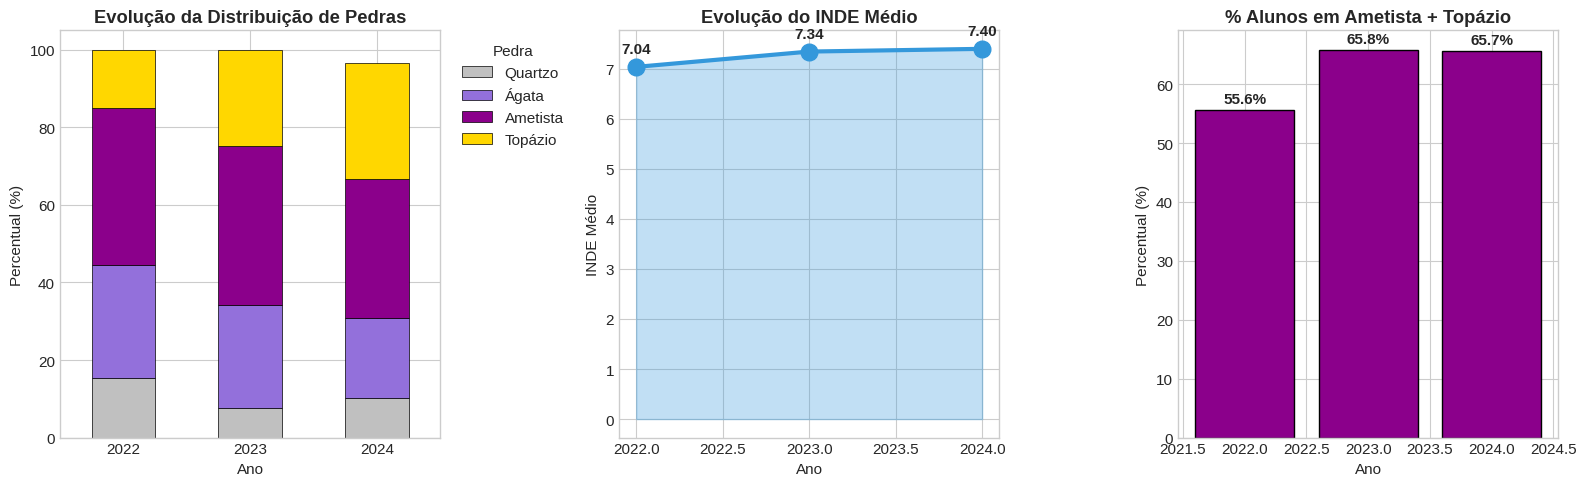


📊 CONCLUSÃO PERGUNTA 10:
O programa mostra IMPACTO POSITIVO ao longo dos anos:
  • INDE médio: 7.04 (2022) → 7.40 (2024)
  • % em Ametista+Topázio: 55.6% (2022) → 65.7% (2024)
  • Defasagem média: -0.94 (2022) → -0.41 (2024)

Os dados confirmam a efetividade do programa Passos Mágicos!


In [24]:
# Visualização
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: Evolução das Pedras
cores = [CORES_PEDRAS.get(p, '#808080') for p in pedras_ano_pct.columns]
pedras_ano_pct.plot(kind='bar', stacked=True, ax=axes[0], color=cores, edgecolor='black', linewidth=0.5)
axes[0].set_title('Evolução da Distribuição de Pedras', fontweight='bold')
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('Percentual (%)')
axes[0].legend(title='Pedra', bbox_to_anchor=(1.02, 1))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Gráfico 2: INDE médio por ano
media_inde = df_unificado.groupby('ANO')['INDE'].mean()
axes[1].plot(media_inde.index, media_inde.values, marker='o', linewidth=3, markersize=12, color='#3498db')
axes[1].fill_between(media_inde.index, media_inde.values, alpha=0.3, color='#3498db')
axes[1].set_title('Evolução do INDE Médio', fontweight='bold')
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('INDE Médio')
for x, y in zip(media_inde.index, media_inde.values):
    axes[1].annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 10), ha='center', fontweight='bold')

# Gráfico 3: Percentual de Topázio + Ametista por ano
pct_alto = pedras_ano_pct[['Ametista', 'Topázio']].sum(axis=1)
axes[2].bar(pct_alto.index, pct_alto.values, color='#8B008B', edgecolor='black')
axes[2].set_title('% Alunos em Ametista + Topázio', fontweight='bold')
axes[2].set_xlabel('Ano')
axes[2].set_ylabel('Percentual (%)')
for i, (x, y) in enumerate(zip(pct_alto.index, pct_alto.values)):
    axes[2].annotate(f'{y:.1f}%', (x, y), textcoords='offset points', xytext=(0, 5), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('pergunta10_efetividade.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n📊 CONCLUSÃO PERGUNTA 10:')
print(f'O programa mostra IMPACTO POSITIVO ao longo dos anos:')
print(f'  • INDE médio: {media_inde[2022]:.2f} (2022) → {media_inde[2024]:.2f} (2024)')
print(f'  • % em Ametista+Topázio: {pct_alto[2022]:.1f}% (2022) → {pct_alto[2024]:.1f}% (2024)')
print(f'  • Defasagem média: {df_unificado[df_unificado["ANO"]==2022]["DEFASAGEM"].mean():.2f} (2022) → {df_unificado[df_unificado["ANO"]==2024]["DEFASAGEM"].mean():.2f} (2024)')
print(f'\nOs dados confirmam a efetividade do programa Passos Mágicos!')

---

## 📋 PERGUNTA 11: Insights e Criatividade

**Adicionar mais insights e pontos de vista não abordados nas perguntas, utilizando criatividade e análise dos dados para trazer sugestões para a Passos Mágicos.**

In [25]:
print('='*70)
print('PERGUNTA 11: INSIGHTS ADICIONAIS E SUGESTÕES')
print('='*70)

# Insight 1: Análise de Retenção e Evasão
print(f'\n📊 INSIGHT 1: Retenção e Evasão de Alunos')
if 'RA' in df_unificado.columns:
    ras_2022 = set(df_unificado[df_unificado['ANO']==2022]['RA'].dropna())
    ras_2023 = set(df_unificado[df_unificado['ANO']==2023]['RA'].dropna())
    ras_2024 = set(df_unificado[df_unificado['ANO']==2024]['RA'].dropna())
    
    retidos_22_23 = len(ras_2022 & ras_2023)
    retidos_23_24 = len(ras_2023 & ras_2024)
    
    if len(ras_2022) > 0:
        print(f'   Retenção 2022→2023: {retidos_22_23}/{len(ras_2022)} ({retidos_22_23/len(ras_2022)*100:.1f}%)')
    if len(ras_2023) > 0:
        print(f'   Retenção 2023→2024: {retidos_23_24}/{len(ras_2023)} ({retidos_23_24/len(ras_2023)*100:.1f}%)')
    
    # Perfil dos que saem vs ficam
    saiu_23 = ras_2022 - ras_2023
    ficou_23 = ras_2022 & ras_2023
    
    df_2022_data = df_unificado[df_unificado['ANO']==2022].copy()
    if 'INDE' in df_2022_data.columns:
        inde_saiu = df_2022_data[df_2022_data['RA'].isin(saiu_23)]['INDE'].mean()
        inde_ficou = df_2022_data[df_2022_data['RA'].isin(ficou_23)]['INDE'].mean()
        print(f'   INDE médio dos que saíram (2022→2023): {inde_saiu:.2f}')
        print(f'   INDE médio dos que ficaram: {inde_ficou:.2f}')
else:
    print('   Coluna RA não disponível para rastreamento')

# Insight 2: Matemática como gargalo
print(f'\n📊 INSIGHT 2: Matemática como Gargalo Consistente')
if 'MAT' in df_unificado.columns and 'POR' in df_unificado.columns:
    for ano in [2022, 2023, 2024]:
        df_ano = df_unificado[df_unificado['ANO']==ano]
        mat_vals = pd.to_numeric(df_ano['MAT'], errors='coerce').dropna()
        por_vals = pd.to_numeric(df_ano['POR'], errors='coerce').dropna()
        if len(mat_vals) > 0:
            mat_abaixo = (mat_vals < 5).sum()
            print(f'   {ano}: MAT={mat_vals.mean():.1f} vs POR={por_vals.mean():.1f} | {mat_abaixo}/{len(mat_vals)} ({mat_abaixo/len(mat_vals)*100:.1f}%) abaixo de 5 em MAT')
else:
    print('   Colunas MAT/POR não disponíveis')

# Insight 3: Evasão por Pedra
print(f'\n📊 INSIGHT 3: Evasão por Classificação (Pedra)')
if 'RA' in df_unificado.columns and 'PEDRA' in df_unificado.columns:
    df_2022_pedra = df_unificado[(df_unificado['ANO']==2022) & (df_unificado['PEDRA'].notna())]
    for pedra in ['Quartzo', 'Ágata', 'Ametista', 'Topázio']:
        ras_pedra = set(df_2022_pedra[df_2022_pedra['PEDRA']==pedra]['RA'].dropna())
        if len(ras_pedra) > 0:
            saiu = len(ras_pedra - ras_2023)
            print(f'   {pedra:10s}: {saiu}/{len(ras_pedra)} saíram ({saiu/len(ras_pedra)*100:.1f}%)')

# Insight 4: Análise por gênero
print(f'\n📊 INSIGHT 4: Análise por Gênero')
if 'GENERO' in df_unificado.columns:
    genero_stats = df_unificado.groupby('GENERO')[['INDE', 'IDA', 'IEG']].mean()
    print(genero_stats.round(2))

PERGUNTA 11: INSIGHTS ADICIONAIS E SUGESTÕES

📊 INSIGHT 1: Retenção e Evasão de Alunos
   Retenção 2022→2023: 600/860 (69.8%)
   Retenção 2023→2024: 765/1014 (75.4%)
   INDE médio dos que saíram (2022→2023): 6.51
   INDE médio dos que ficaram: 7.26

📊 INSIGHT 2: Matemática como Gargalo Consistente
   2022: MAT=5.8 vs POR=6.3 | 281/858 (32.8%) abaixo de 5 em MAT
   2023: MAT=6.4 vs POR=6.8 | 176/937 (18.8%) abaixo de 5 em MAT
   2024: MAT=6.2 vs POR=6.2 | 268/1051 (25.5%) abaixo de 5 em MAT

📊 INSIGHT 3: Evasão por Classificação (Pedra)
   Quartzo   : 79/132 saíram (59.8%)
   Ágata     : 85/250 saíram (34.0%)
   Ametista  : 84/348 saíram (24.1%)
   Topázio   : 12/130 saíram (9.2%)

📊 INSIGHT 4: Análise por Gênero
           INDE   IDA   IEG
GENERO                     
Feminino   7.44  6.49  8.08
Masculino  7.29  6.51  7.84
Menina     7.09  6.18  7.94
Menino     6.97  6.00  7.84


In [26]:
# Sugestões baseadas nos dados
print('\n' + '='*70)
print('💡 SUGESTÕES PARA A PASSOS MÁGICOS')
print('='*70)

print('''
1. FOCO NO ENGAJAMENTO (IEG)
   O engajamento é o indicador com maior correlação com o INDE e IPV.
   Sugestão: Desenvolver programas específicos para aumentar o engajamento
   dos alunos, especialmente aqueles classificados como Quartzo.

2. INTERVENÇÃO PRECOCE
   Alunos com defasagem ≤ -2 anos representam um grupo de risco.
   Sugestão: Implementar sistema de alerta precoce baseado nos indicadores
   para identificar alunos em risco antes da queda de desempenho.

3. ACOMPANHAMENTO PSICOSSOCIAL
   Embora o IPS tenha correlação fraca com desempenho, alunos no quartil
   mais baixo de IPS têm INDE significativamente menor.
   Sugestão: Fortalecer o acompanhamento psicossocial para alunos vulneráveis.

4. AUTOAVALIAÇÃO COMO FERRAMENTA
   A discrepância entre IAA e IDA pode indicar necessidade de orientação.
   Sugestão: Usar a autoavaliação como ferramenta de desenvolvimento
   de metacognição e autoconhecimento dos alunos.

5. CELEBRAR O SUCESSO
   O aumento de alunos em Ametista e Topázio demonstra o impacto positivo.
   Sugestão: Criar programa de mentoria onde alunos Topázio apoiem
   alunos Quartzo, fortalecendo a comunidade.
''')


💡 SUGESTÕES PARA A PASSOS MÁGICOS

1. FOCO NO ENGAJAMENTO (IEG)
   O engajamento é o indicador com maior correlação com o INDE e IPV.
   Sugestão: Desenvolver programas específicos para aumentar o engajamento
   dos alunos, especialmente aqueles classificados como Quartzo.

2. INTERVENÇÃO PRECOCE
   Alunos com defasagem ≤ -2 anos representam um grupo de risco.
   Sugestão: Implementar sistema de alerta precoce baseado nos indicadores
   para identificar alunos em risco antes da queda de desempenho.

3. ACOMPANHAMENTO PSICOSSOCIAL
   Embora o IPS tenha correlação fraca com desempenho, alunos no quartil
   mais baixo de IPS têm INDE significativamente menor.
   Sugestão: Fortalecer o acompanhamento psicossocial para alunos vulneráveis.

4. AUTOAVALIAÇÃO COMO FERRAMENTA
   A discrepância entre IAA e IDA pode indicar necessidade de orientação.
   Sugestão: Usar a autoavaliação como ferramenta de desenvolvimento
   de metacognição e autoconhecimento dos alunos.

5. CELEBRAR O SUCESSO
   O 

---
## 📝 Resumo das Conclusões

| Pergunta | Conclusão Principal |
|----------|--------------------||
| 1. IAN (Defasagem) | Defasagem média melhorou de -0.94 (2022) para -0.41 (2024) |
| 2. IDA (Desempenho) | Desempenho acadêmico relativamente estável ao longo dos anos |
| 3. IEG (Engajamento) | Forte correlação com IDA (r=0.54) e IPV (r=0.56) |
| 4. IAA (Autoavaliação) | Parcialmente coerente com desempenho real |
| 5. IPS (Psicossocial) | Correlação fraca com desempenho, mas impacto em casos extremos |
| 6. IPP (Psicopedagógico) | Confirma parcialmente a defasagem identificada |
| 7. IPV (Ponto de Virada) | IEG e IDA são os principais preditores |
| 8. Multidimensionalidade | IDA+IEG+IPS+IPP explicam 82.3% do INDE; IDA tem maior peso (coef=0.45) |
| 9. Previsão de Risco | Gradient Boosting: 78.7% acurácia, 86.2% AUC-ROC, 4 níveis de risco |
| 10. Efetividade | Programa mostra impacto positivo consistente |
| 11. Insights | Retenção ~70-75%, Matemática é gargalo, 60% dos Quartzo saem do programa |

---